# Model 0.14 - Further Description Features
- English Description Flag
- Tried language flags but made errors for small amounts of text
- Website flag based on whether included a few keywords e.g. "www."
- Slight drop in LB

In [1]:
import re
import itertools
import ml_metrics
import string
import nltk
import scipy
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from functools import lru_cache
from scipy.sparse import hstack
# from scipy.ndimage.filters import gaussian_filter1d as gaussian
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            precision_recall_curve, \
                            log_loss, \
                            roc_auc_score, \
                            roc_curve
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

/home/rich/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# hides warnings - think it needs running after modules imported
import warnings
warnings.simplefilter("ignore")

In [3]:
rnd = 42  # random state for scoring consistency

## Importing the data

In [4]:
df_train = pd.read_csv("../input/train/train.csv", index_col="PetID")
df_test = pd.read_csv("../input/test/test.csv", index_col="PetID")
df_breeds = pd.read_csv("../input/breed_labels.csv", index_col="BreedID")
df_colors = pd.read_csv("../input/color_labels.csv")

In [5]:
colors = df_colors['ColorID']
breeds = df_breeds.index

## Functions

### Functions: Feature Engineering

In [6]:
def apply_word_flags(df, words, drop=True):
    """Creates binary columns for words which appear in the description"""
    for word in words:
        df[word] = 0
    for i, desc in df['Description'].items():
        try:
            for word in desc.split():
                word = word.lower()
                if word in words:
                    df.at[i,word] = 1
        except AttributeError:
            continue
    return df.drop(columns=['Description'] if drop else [])

In [7]:
keywords = ['home', 'good' , 'adopt', 'loving', 'give', 'looking', 'playful', 'rescued', 'cat', 'contact']

In [8]:
def apply_color_flags(df, colors):
    """Combines Colors 1,2 & 3 into binary columns for each possible colours"""
    for c in colors:
        df[f'C{c}'] = 0
    for i,colors in df[['Color1', 'Color2', 'Color3']].iterrows():
        for c in colors:
            if c != 0:
                df.at[i,f'C{c}'] = 1
    df = df.drop(columns=['Color1', 'Color2', 'Color3'])
    return df

In [9]:
def create_breed_keywords(df):
    """Creates unique list of keywords from provided breeds dataframe"""
    breed_keywords = []
    for breed in df['BreedName']:
        breed = re.sub(r'[/(/)]', '', breed)  # remove braces
        keywords = breed.split()
        breed_keywords += keywords
    return set(breed_keywords)

In [10]:
def apply_breed_flags(df, keywords, breeds):
    """Creates binary columns for keywords which appear in the breed name"""
    for word in keywords:
        df[word] = 0
        
    for i,pair in df[['Breed1', 'Breed2']].iterrows():
        for indx in pair:
            if indx == 0: continue
            breed = breeds.loc[indx,'BreedName']
            breed = re.sub(r'[/(/)]', '', breed)
            new_keywords = breed.split()
            for word in new_keywords:
                if word in keywords: 
                    df.at[i,word] = 1
                    
    return df

### Functions: Scoring 

In [11]:
# Kappa weighted prediction, also taking into account natural distribution of training truth values
@lru_cache(maxsize=128)
def quad_weights(i, n=5):
    return 1-(i**2 / (n-1)**2)

def weighted_prediction(proba, defaults):
    prediction = []
    for row in proba:
        row = [p-defaults[i] if p-defaults[i] > 0 else 0 for i,p in enumerate(row)]
        k_lst = []
        for i in range(len(row)):
            k_score = sum([p * quad_weights(abs(i-j)) for j, p in enumerate(row)])
            k_lst.append(k_score)
        prediction.append(np.argmax(k_lst))
    return prediction           

### Functions: Analyse Model 

In [12]:
# function from sklearn website example code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Preparing data

In [13]:
# Combine test and training data
df_combined = pd.concat([df_test, df_train], sort=False)
df_combined['test'] = df_combined['AdoptionSpeed'].isna()
df_combined['Description'] = df_combined['Description'].fillna('')

# Rescuer
rescue_map = Counter(df_combined['RescuerID'])
rescuer_counts = df_combined['RescuerID'].map(rescue_map)

# Breeds
all_test_breeds = df_test['Breed1'].append(df_test['Breed2'])
df_test_breeds = df_breeds.loc[all_test_breeds[all_test_breeds > 0].unique(), :]
breed_keywords = create_breed_keywords(df_test_breeds)

# Prepare data for modelling 
df_combined['rescuer_counts'] = rescuer_counts
df_combined['desc_length'] = df_combined['Description'].apply(len)
df_combined['desc_word_count'] = df_combined['Description'].apply(lambda x: len(x.split()))

df_combined = apply_word_flags(df_combined, keywords, drop=False)
df_combined = apply_color_flags(df_combined, colors)
df_combined = apply_breed_flags(df_combined, breed_keywords, df_breeds)
df_combined = pd.get_dummies(df_combined, columns=['Gender',
                                                   'Vaccinated', 'Dewormed', 'Sterilized', 
                                                   'State'])
y_train_all = df_combined['AdoptionSpeed'][df_combined['test'] != 1]
X_all       = df_combined.drop(columns=['Name', 'RescuerID', 'AdoptionSpeed', 'Breed1', 'Breed2'])
X_train_all = X_all[X_all['test'] != 1].drop(columns=['test'])
X_test_all  = X_all[X_all['test'] == 1].drop(columns=['test'])

### Check Description English or not?

In [14]:
# check for all languages - not enough words in text so not accurate
def language_flag(text, english_flag=True):
    language_ratios = {}
    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]
    for language in stopwords.fileids():
        common_elements = set(words) & set(stopwords.words(language))
        language_ratios[language] = len(common_elements)
    language = max(language_ratios, key=language_ratios.get)
    if english_flag:
        return language_ratios['english'] > 0
    else:
        return "language_" + language 

In [15]:
# check for specific language - defaults to english
def language_flag(text, language='english'):
    tokens = wordpunct_tokenize(text)
    words = set([word.lower() for word in tokens])
    keywords = set(stopwords.words(language))
    common_words = words & keywords
    return len(common_words) > 0

In [16]:
X_train_all['english'] = X_train_all['Description'].apply(language_flag)

In [17]:
X_test_all['english'] = X_test_all['Description'].apply(language_flag)

### Contains a website?
I'd expect those descriptions with a website to be a third party shelter, to help determine rescuer type

In [18]:
def website_flag(text):
    keywords = ['www.', '.org', '.my', '.com']
    match = map(lambda x: text.find(x) >= 0, keywords)
    return sum(match) > 0

In [19]:
X_train_all['website'] = X_train_all['Description'].apply(website_flag)
Counter(X_train_all['website'])

Counter({False: 14896, True: 97})

In [20]:
X_test_all['website'] = X_test_all['Description'].apply(website_flag)

### Count Punctuation

In [21]:
# def punc_flag(text):
#     return text.count('.')

In [22]:
# X_train_all['punctuation'] = X_train_all['Description'].apply(punc_flag)
# Counter(X_train_all['punctuation']).most_common(5)

In [23]:
# remove description feature
X_train_all = X_train_all.drop(columns=['Description'])
X_test_all  = X_test_all.drop(columns=['Description'])

## Test XGBoost model

In [24]:
params = {'max_depth': 4, 
          'learning_rate': 0.2, 
          'n_estimators': 200, 
          'silent': True, 
          'objective': 'multi:softprob', 
          'booster': 'gbtree',
          'tree_method': 'hist',
          'n_jobs': 3,
          'gamma': 0, 
          'min_child_weight': 1, 
          'max_delta_step': 0, 
          'subsample': 0.8, 
          'colsample_bytree': 1, 
          'colsample_bylevel': 1, 
          'reg_alpha': 0, 
          'reg_lambda': 1, 
          'scale_pos_weight': 1, 
          'base_score': 0.2, 
          'random_state': rnd, 
          'missing': None,
          'verbose': 0,
          'verbosity': 3,}

In [25]:
def cv_testing(X_train_all, params, folds=5, dataframe=True):

    scores = defaultdict(list)

    folds = KFold(folds, True, rnd).split(X_train_all)

    for i, (train_indx, test_indx) in enumerate(folds, 1):
        
        print(f"Fold {i}")
        
        # flag dataframe determines whether to use iloc or "normal" masking for (sparse) arrays
        if not dataframe:
            X_train, X_test = X_train_all[train_indx], X_train_all[test_indx]
            y_train, y_test = y_train_all[train_indx], y_train_all[test_indx]
        else:
            X_train, X_test = X_train_all.iloc[train_indx], X_train_all.iloc[test_indx]
            y_train, y_test = y_train_all.iloc[train_indx], y_train_all.iloc[test_indx]


        clf = xgb.XGBClassifier(**params)

        clf.fit(X_train, y_train)

#         prediction = clf.predict(X_test)
        proba = clf.predict_proba(X_test)
        
        # alternative kappa weighted consideration
        total_count = y_train.shape[0]
        defaults = {k:v/total_count for k,v in Counter(y_train).items()}
        prediction = weighted_prediction(proba, defaults)
        

        scores['kappa'].append(ml_metrics.quadratic_weighted_kappa(rater_a=y_test, rater_b=prediction))
        scores['accuracy'].append(accuracy_score(y_test, prediction))
        scores['confusion'].append(confusion_matrix(y_test, prediction))
        scores['precision'].append(precision_score(y_test, prediction, average=None))        
    
    print()
    
    return scores

In [26]:
scores = cv_testing(X_train_all=X_train_all, folds=10, params=params, dataframe=True)

Fold 1
[15:47:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[15:47:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[15:47:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 4
[15:47:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 5
[15:47:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 6
[15:47:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 7
[15:48:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 8
[15:48:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 9
[15:48:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 10
[15:48:28] Tree method is selected to be 'hist'

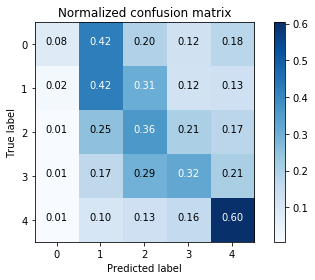

In [27]:
# plot normalised (by row) confusion matrix
cm = sum(scores['confusion'])  # sums element-wise
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

<BarContainer object of 5 artists>

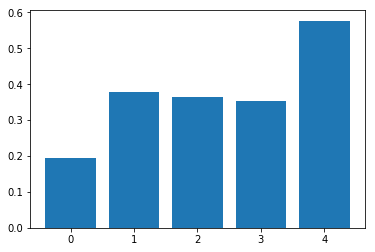

In [28]:
# plot average precision for each class
plt.bar([0,1,2,3,4], sum(scores['precision']) / len(scores['precision']))

In [29]:
# 0.413 --> 0.415 (English description flag)
# 0.415 --> 0.411 (estimate language flag, with one hot encoding)
# 0.415 --> 0.413 (website flag - contains "www")
# 0.415 --> 0.416 (website flag - contains www. .org .my or .com)
# 0.416 --> 0.411 (punctuation flag - both full stops and commas)
# 0.416 --> 0.411 (punctuation flag - full stops)
print("kappa:    {:.3}".format(np.mean(scores['kappa'])))
print("accuracy: {:.3}".format(np.mean(scores['accuracy'])))

kappa:    0.414
accuracy: 0.426


# Run model on test data

In [30]:
clf = xgb.XGBClassifier(**params)
clf.fit(X_train_all, y_train_all)
proba = clf.predict_proba(X_test_all)
total_count = y_train_all.shape[0]
defaults = {k:v/total_count for k,v in Counter(y_train_all).items()}
prediction = weighted_prediction(proba, defaults)

[15:48:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


# Model Analysis

### Feature Importance

In [31]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train_all.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

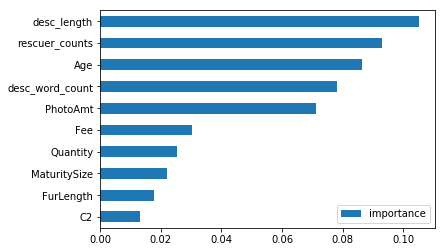

In [32]:
# top 10 features
feature_importances.iloc[:10,:][::-1].plot.barh()

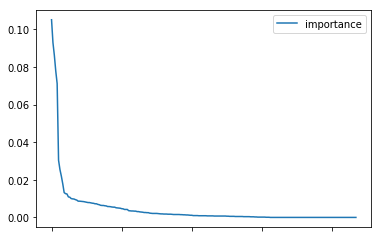

In [33]:
# distribution of feature importance
feature_importances.plot()

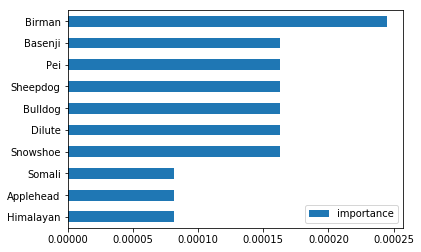

In [34]:
# bottom 10 least important features
feature_importances[feature_importances['importance'] > 0].iloc[-10:,:][::-1].plot.barh()

In [35]:
# count of non-importance features
not_important = feature_importances[feature_importances['importance'] == 0]
len(not_important)

62

In [36]:
not_important.index

Index(['Coon', 'Sheltie', 'Sheep', 'Ragamuffin', 'Old', 'Pyrenees', 'King',
       'Devon', 'Tibetan', 'Chinese', 'Fila', 'Cairn', 'Italian', 'French',
       'Shar', 'Ocicat', 'Fell', 'Eskimo', 'Shorthaired', 'Mixed', 'Parson',
       'Patterdale', 'Havanese', 'Malamute', 'Cattle', 'Afghan', 'Great',
       'Saint', 'State_41415', 'Lakeland', 'Akita', 'Westie', 'Cymric',
       'Forest', 'Bernard', 'Inu', 'Greyhound', 'Standard', 'Foo', 'Rex',
       'Laekenois', 'Shetland', 'Brasileiro', 'Ridgeback', 'Chausie', 'Mau',
       'Highland', 'Whippet', 'Chinchilla', 'Heeler', 'Pixie-Bob', 'Russian',
       'Munchkin', 'Alaskan', 'Irish', 'Tzu', 'Mountain', 'Cavalier',
       'Charles', 'West', 'DogBlue', 'Jack'],
      dtype='object')

In [37]:
# X_train_all = X_train_all.drop(columns=list(not_important.index))
# X_test_all = X_test_all.drop(columns=list(not_important.index))

# Final run on test model and submission

In [38]:
clf = xgb.XGBClassifier(**params)
clf.fit(X_train_all, y_train_all)
proba = clf.predict_proba(X_test_all)
total_count = y_train_all.shape[0]
defaults = {k:v/total_count for k,v in Counter(y_train_all).items()}
prediction = np.array(weighted_prediction(proba, defaults))

[15:48:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


In [39]:
submission = pd.DataFrame({'AdoptionSpeed': prediction.astype(int)}, index=X_test_all.index)
submission.to_csv("submission.csv", index=True, index_label='PetID', header=['AdoptionSpeed'])